In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from datetime import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, classification_report
import sidetable
import matplotlib.ticker as ticker
from datetime import timedelta
import re
from sklearn.preprocessing import StandardScaler
import matplotlib.dates as mdates
from Olist_classes import Olist_analysis as oa
import plotly as py
import plotly.offline as offline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Figure, Layout
from plotly import tools
init_notebook_mode(connected=True)
from scipy import stats 
import math
import random
from surprise import accuracy, Reader, Dataset
from surprise import  SVD, SVDpp
from surprise.model_selection import cross_validate, KFold, GridSearchCV, train_test_split
from collections import defaultdict
import calendar
import spacy
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
products = pd.read_csv('archive/olist_products_dataset.csv')
customer = pd.read_csv('archive/olist_customers_dataset.csv')
geolocation = pd.read_csv('archive/olist_geolocation_dataset.csv')
orders = pd.read_csv("archive/olist_orders_dataset.csv")
order_items = pd.read_csv('archive/olist_order_items_dataset.csv')
order_payments = pd.read_csv('archive/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('archive/olist_order_reviews_dataset.csv')
sellers = pd.read_csv('archive/olist_sellers_dataset.csv')
products_trans = pd.read_csv('archive/olist_products_dataset_translated.csv')

## Business Trend Analysis

In [3]:
orders.shape

(99441, 8)

In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [5]:
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [6]:
# Creating timestamp columns
orders['order_time'] = pd.to_datetime(orders['order_purchase_timestamp']).dt.time
orders['delivery_time'] = pd.to_datetime(orders['order_delivered_carrier_date']).dt.time

In [7]:
orders['delivery_time']

0        19:55:00
1        14:31:00
2        13:50:00
3        13:39:59
4        19:46:34
           ...   
99436    11:18:03
99437    23:22:42
99438    20:52:26
99439    15:35:03
99440    22:11:59
Name: delivery_time, Length: 99441, dtype: object

In [8]:
def convert_to_dt(df, columns):
    for column in columns:
       df[column] = pd.to_datetime(df[column]).dt.date

In [9]:
#converting date
convert_to_dt(orders, ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
orders.sort_values(by = 'order_purchase_timestamp', inplace = True)

In [10]:
# Substitute missing date values through forward fill:
for col in [
    'order_delivered_customer_date',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'delivery_time'
    ]:
    orders[col].ffill(inplace = True)

# check:
print('Missing values: ', orders['order_delivered_customer_date'].isnull().sum())

Missing values:  3


In [11]:
orders.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    3
order_estimated_delivery_date    0
order_time                       0
delivery_time                    0
dtype: int64

In [12]:
# Adding ordinal date column:
orders['date_ordinal'] = orders['order_purchase_timestamp'].apply(lambda date: date.toordinal())

In [13]:
orders['shipping_time_delta'] = orders['order_estimated_delivery_date'] - orders['order_delivered_customer_date']
orders['shipping_duration'] = orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']
orders['estimated_duration'] = orders['order_estimated_delivery_date'] - orders['order_purchase_timestamp']

In [14]:
# Collections for each dataset
datasets = [customer, geolocation, orders, order_items, order_payments,
            order_reviews, products, sellers]
names = ['customer', 'geolocation', 'orders', 'order_items', 'order_payments',
         'order_reviews', 'products', 'sellers']

In [15]:
# Creating a DataFrame for all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['perc_null'] = [df.isnull().sum().sum() / (df.shape[0]) for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient()

,dataset,n_rows,n_cols,null_amount,perc_null,qty_null_columns,null_columns
0,customer,99441,5,0,0.000000,0,
1,geolocation,1000163,5,0,0.000000,0,
2,orders,99441,14,9,0.000091,3,"order_delivered_customer_date, shipping_time_delta, shipping_duration"
3,order_items,112650,7,0,0.000000,0,
4,order_payments,103886,5,0,0.000000,0,
5,order_reviews,99224,7,145903,1.470441,2,"review_comment_title, review_comment_message"
6,products,32951,9,2448,0.074292,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,sellers,3095,4,0,0.000000,0,


In [16]:
#Merge all the dataset into one dataframe
merged_df = orders.merge(order_items, on='order_id', how='left')
merged_df = merged_df.merge(order_payments, on='order_id', how='outer', validate='m:m')
#merged_df = merged_df.merge(order_reviews, on='order_id', how='outer')
merged_df = merged_df.merge(products, on='product_id', how='outer')
merged_df = merged_df.merge(customer, on='customer_id', how='outer')
df = merged_df.merge(sellers, on='seller_id', how='outer')

print(df.shape)

(118434, 39)


In [17]:
order_reviews.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118434 entries, 0 to 118433
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       118434 non-null  object 
 1   customer_id                    118434 non-null  object 
 2   order_status                   118434 non-null  object 
 3   order_purchase_timestamp       118434 non-null  object 
 4   order_approved_at              118434 non-null  object 
 5   order_delivered_carrier_date   118434 non-null  object 
 6   order_delivered_customer_date  118430 non-null  object 
 7   order_estimated_delivery_date  118434 non-null  object 
 8   order_time                     118434 non-null  object 
 9   delivery_time                  118434 non-null  object 
 10  date_ordinal                   118434 non-null  int64  
 11  shipping_time_delta            118430 non-null  object 
 12  shipping_duration             

# Drop NaN Values
#nan_rows = df[df.isna().any(axis=1)]
missing_val = len(nan_rows)/len(df)*100
print(f"There are {missing_val:.2f}% percentage of missing value")



df.dropna(inplace=True)

In [19]:
df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   0
order_delivered_carrier_date        0
order_delivered_customer_date       4
order_estimated_delivery_date       0
order_time                          0
delivery_time                       0
date_ordinal                        0
shipping_time_delta                 4
shipping_duration                   4
estimated_duration                  0
order_item_id                     830
product_id                        830
seller_id                         830
shipping_limit_date               830
price                             830
freight_value                     830
payment_sequential                  3
payment_type                        3
payment_installments                3
payment_value                       3
product_category_name            2528
product_name_lenght              2528
product_desc

In [20]:
products_trans.rename(columns={'product_category_name':'product_category_name_english'},inplace=True)
df = pd.merge(df,products_trans[['product_id','product_category_name_english']], on='product_id', how='outer')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118434 entries, 0 to 118433
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       118434 non-null  object 
 1   customer_id                    118434 non-null  object 
 2   order_status                   118434 non-null  object 
 3   order_purchase_timestamp       118434 non-null  object 
 4   order_approved_at              118434 non-null  object 
 5   order_delivered_carrier_date   118434 non-null  object 
 6   order_delivered_customer_date  118430 non-null  object 
 7   order_estimated_delivery_date  118434 non-null  object 
 8   order_time                     118434 non-null  object 
 9   delivery_time                  118434 non-null  object 
 10  date_ordinal                   118434 non-null  int64  
 11  shipping_time_delta            118430 non-null  object 
 12  shipping_duration             

### Analysing the order price distribution:

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



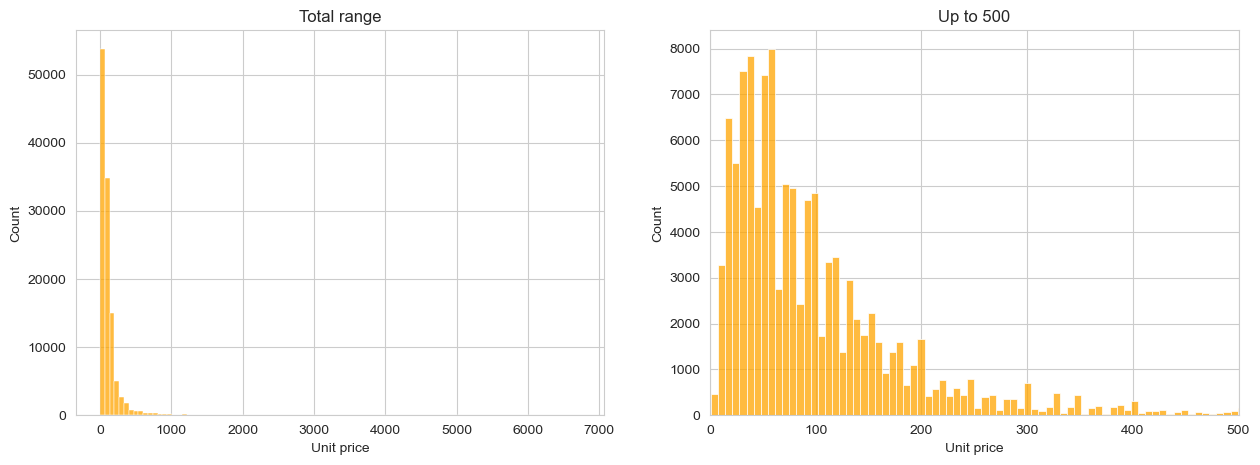

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Set titles for each subplot
ax1.set_title('Total range')
ax2.set_title('Up to 500')

# Set x-axis limit for the second subplot
ax2.set_xlim([0, 500])

# Create the first distribution plot
sns.histplot(df['price'], 
             bins=100, 
             kde=False, 
             color='orange', 
             ax=ax1)
ax1.set_xlabel('Unit price')

# Create the second distribution plot
sns.histplot(df['price'], 
             bins=1000, 
             kde=False, 
             color='orange', 
             ax=ax2)
ax2.set_xlabel('Unit price')

# Display the plot
plt.show()

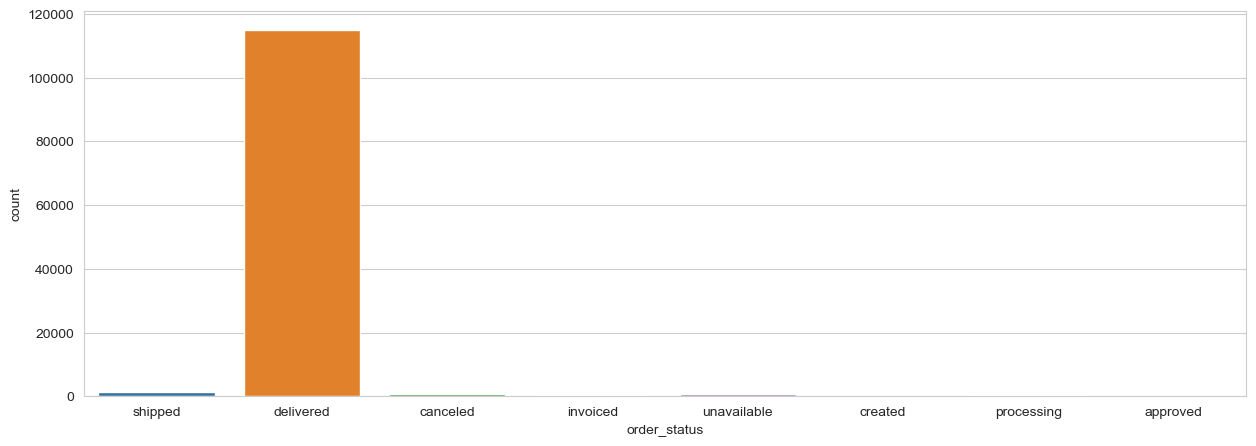

In [23]:
plt.figure(figsize = (15, 5))
sns.countplot(x=df['order_status']);

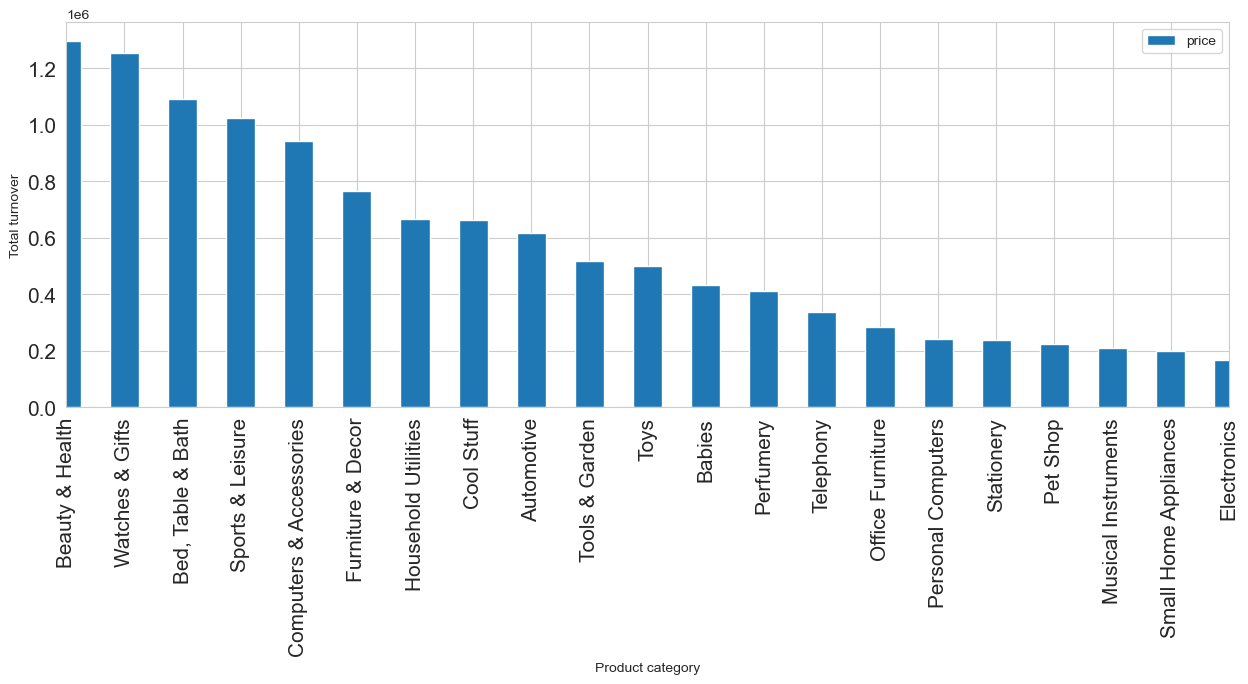

In [24]:
df.groupby('product_category_name_english').agg({'price': 'sum'}).sort_values(by = 'price', ascending = False).plot(kind = "bar", fontsize = 15, figsize = (15, 5))
plt.xlabel('Product category')
plt.ylabel('Total turnover')
plt.xlim(0, 20);

In [25]:
#Show total products and category
print(f"Total Products: {merged_df['product_id'].nunique()}")

categories = merged_df.product_category_name.unique()
category = pd.DataFrame({'category': categories})
category.index += 1
print(f"Total Category: {category.value_counts().sum()}")

Total Products: 32951
Total Category: 73


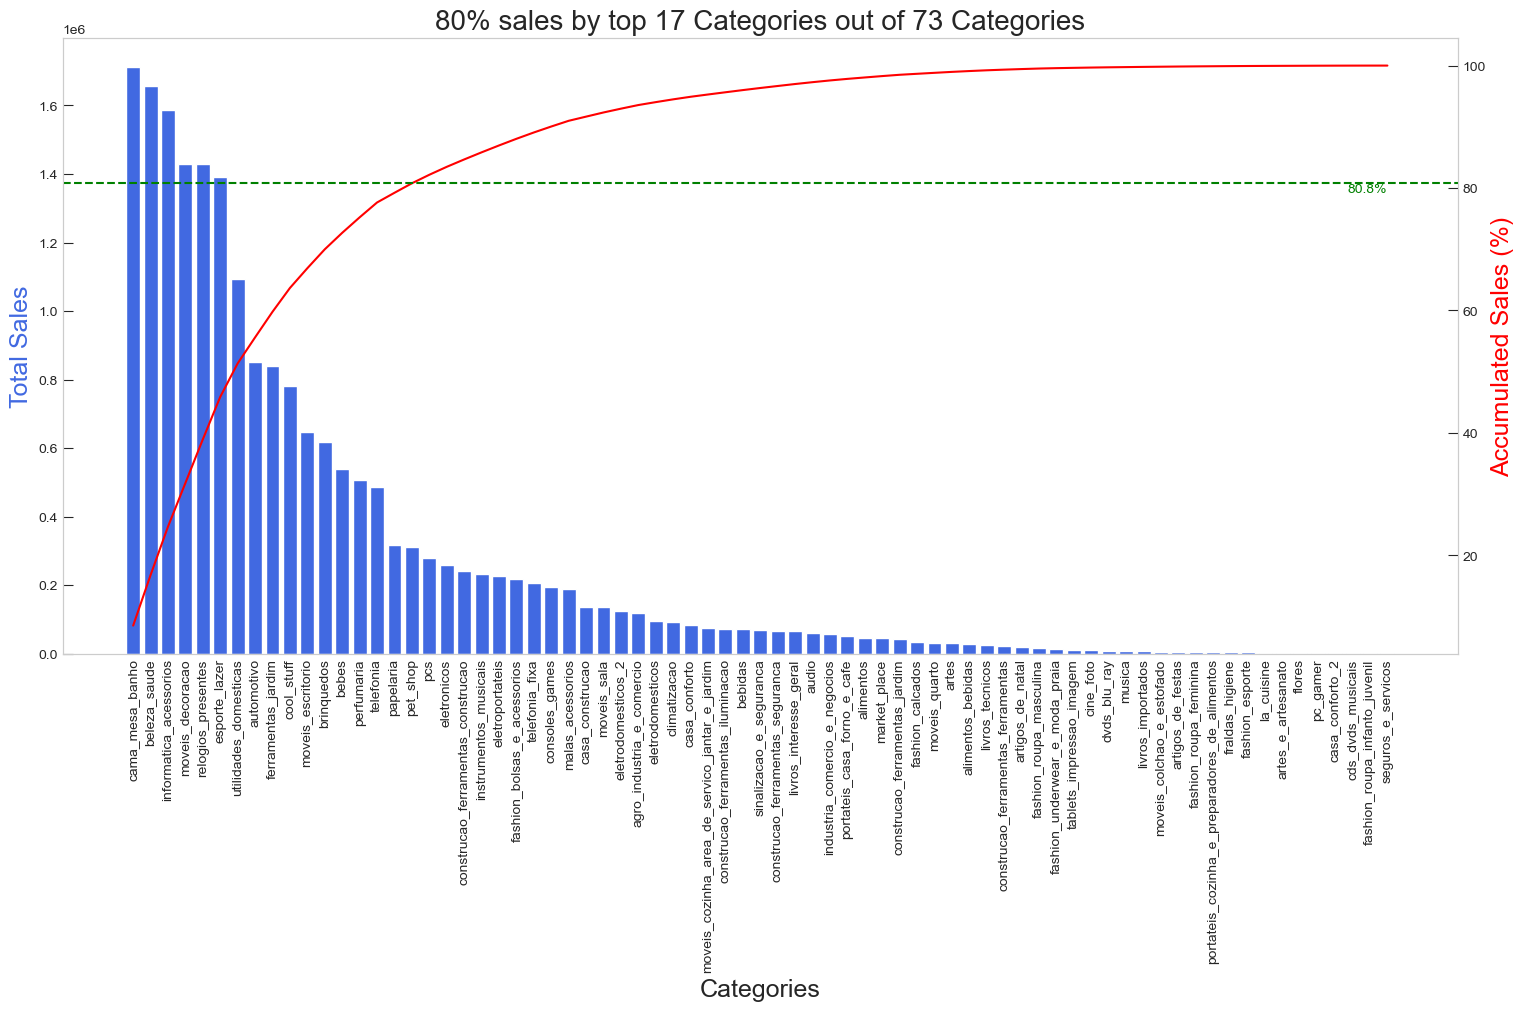

In [26]:
category = merged_df.groupby(['product_category_name']).agg(
total_trans_value=('payment_value', 'sum')).reset_index()
total_sum_cat = category['total_trans_value'].sum()
category_sorted = category.sort_values(by='total_trans_value', ascending=False).reset_index(drop=True)
category_sorted['acc_percent_trans_value'] = category_sorted['total_trans_value'].cumsum().div(total_sum_cat) * 100

category_sorted.index = category_sorted.index + 1
category_sorted['acc_category_count'] = category_sorted.index
category_sorted['acc_percent_cat_count'] = category_sorted['acc_category_count'].div(len(category_sorted.acc_category_count)) * 100

category_sorted.head(25)

# Data
categories = category_sorted.product_category_name
bar_data = category_sorted.total_trans_value
line_data = category_sorted.acc_percent_trans_value

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(18, 8))

# Plot the barplot using Matplotlib
ax1.bar(categories, bar_data, color='#4169E1')
ax1.set_ylabel('Total Sales', color='#4169E1', fontsize=18)

# Set x-axis tick positions and labels
ax1.set_xticks(range(len(categories)))
ax1.set_xticklabels(categories, rotation=90, fontsize=12)  # Rotate x-labels
ax1.tick_params(direction='in', length=7)

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the lineplot using Matplotlib
ax2.plot(categories, line_data, color='red')
ax2.set_ylabel('Accumulated Sales (%)', color='red', fontsize=18)
ax2.tick_params(direction='in', length=7)

# Customize the axes and labels
ax1.set_xlabel('Categories', fontsize=18)
all_cat = len(category_sorted.product_category_name)
ax1.set_title(f'80% sales by top 17 Categories out of {all_cat} Categories', fontsize=20)

# Gridlines
ax1.grid(axis='y', alpha=0)
ax2.grid(axis='y', alpha=0)
ax1.grid(axis='x', alpha=0)
ax2.grid(axis='x', alpha=0)

# Add the horizontal line
line_value = 80.8
ax2.axhline(y=line_value, color='green', linestyle='--')
ax2.text(len(categories) - 1, line_value, f'{line_value}%', va='top', ha='right', color='green')

# Set the font size for tick labels on both axes
ax1.tick_params(axis='both', labelsize=10)
ax2.tick_params(axis='both', labelsize=10)

# Display the chart
plt.show()

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



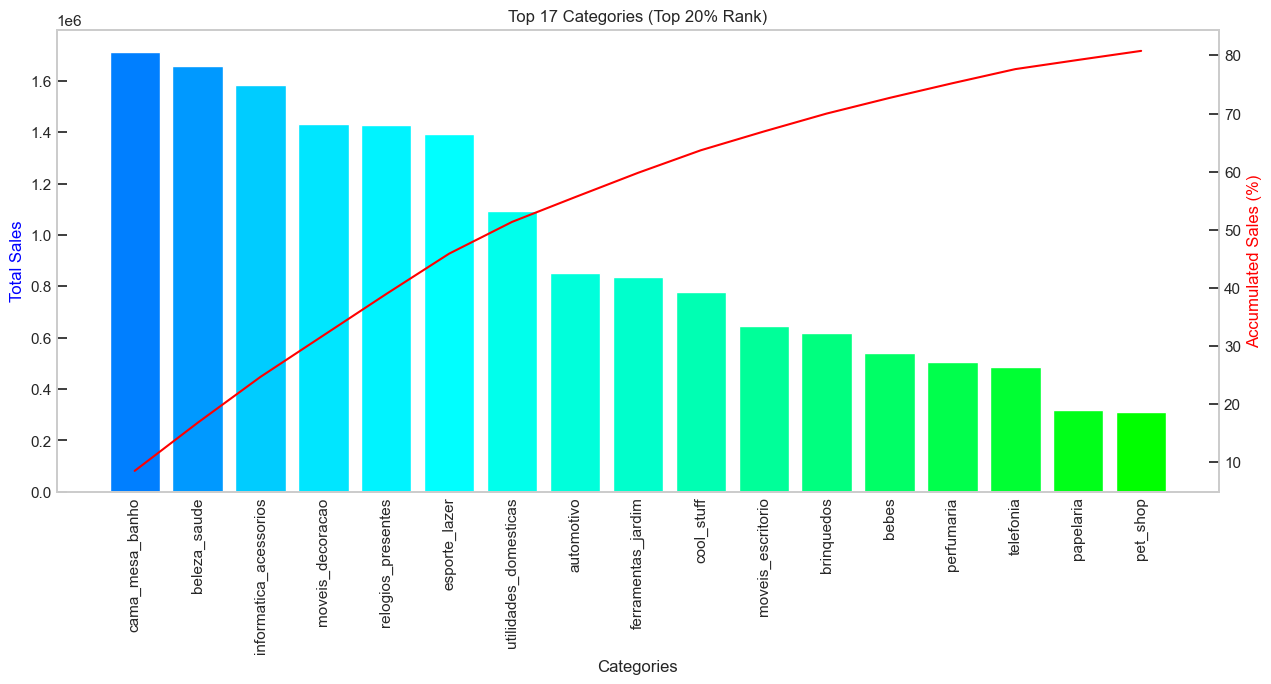

In [27]:
category_sorted['ratio_cat_trans'] = category_sorted['acc_percent_trans_value']/category_sorted['acc_percent_cat_count']

top80_cat = category_sorted.loc[:, category_sorted.columns != "total_category_count"].head(17)
# Sample data
categories = top80_cat.product_category_name
bar_data = top80_cat.total_trans_value
line_data = top80_cat.acc_percent_trans_value

# Define a custom color palette
custom_palette = ['#007FFF', '#0099FF', '#00CCFF', '#00E6FF', '#00F3FF', '#00FFFF', '#00FFEC',
                  '#00FFDB', '#00FFCC', '#00FFB3', '#00FF99', '#00FF7F', '#00FF66', '#00FF4C',
                  '#00FF33', '#00FF19', '#00FF00']

# Set the Seaborn style
sns.set(style="whitegrid")

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot the barplot using Matplotlib
ax1.bar(categories, bar_data, color=custom_palette)
ax1.set_ylabel('Total Sales', color='blue')

# Set x-axis tick positions and labels
ax1.set_xticks(range(len(categories)))
ax1.set_xticklabels(categories, rotation=90)  # Rotate x-labels
ax1.tick_params(direction='in', length=7)

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the lineplot using Seaborn
sns.lineplot(x=categories, y=line_data, color='red', ax=ax2)
ax2.set_ylabel('Accumulated Sales (%)', color='red')
ax2.tick_params(direction='in', length=7)

# Customize the axes and labels
ax1.set_xlabel('Categories')
ax1.set_title('Top 17 Categories (Top 20% Rank)')

# Gridlines
ax1.grid(axis='y', alpha=0)
ax2.grid(axis='y', alpha=0)
ax1.grid(axis='x', alpha=0)
ax2.grid(axis='x', alpha=0)

# Display the chart
plt.show()

 ## How is the monthly sales by top 17 category ?

In [28]:
#Create column of purchase of month
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['purchase_month'] = pd.DatetimeIndex(df['order_purchase_timestamp']).month

In [29]:
df['purchase_month'] = pd.DatetimeIndex(df['order_purchase_timestamp']).month
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118434 entries, 0 to 118433
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       118434 non-null  object        
 1   customer_id                    118434 non-null  object        
 2   order_status                   118434 non-null  object        
 3   order_purchase_timestamp       118434 non-null  datetime64[ns]
 4   order_approved_at              118434 non-null  object        
 5   order_delivered_carrier_date   118434 non-null  object        
 6   order_delivered_customer_date  118430 non-null  datetime64[ns]
 7   order_estimated_delivery_date  118434 non-null  object        
 8   order_time                     118434 non-null  object        
 9   delivery_time                  118434 non-null  object        
 10  date_ordinal                   118434 non-null  int64         
 11  

In [30]:
#Define the category tables for each month
sales_df = df.groupby(['product_category_name'])['payment_value'].sum()
best_sellers = sales_df.nlargest(17).index
best_df = df[df['product_category_name'].isin(best_sellers)]
best_monthly = best_df.pivot_table(index='product_category_name', columns='purchase_month', values='payment_value', aggfunc='sum')

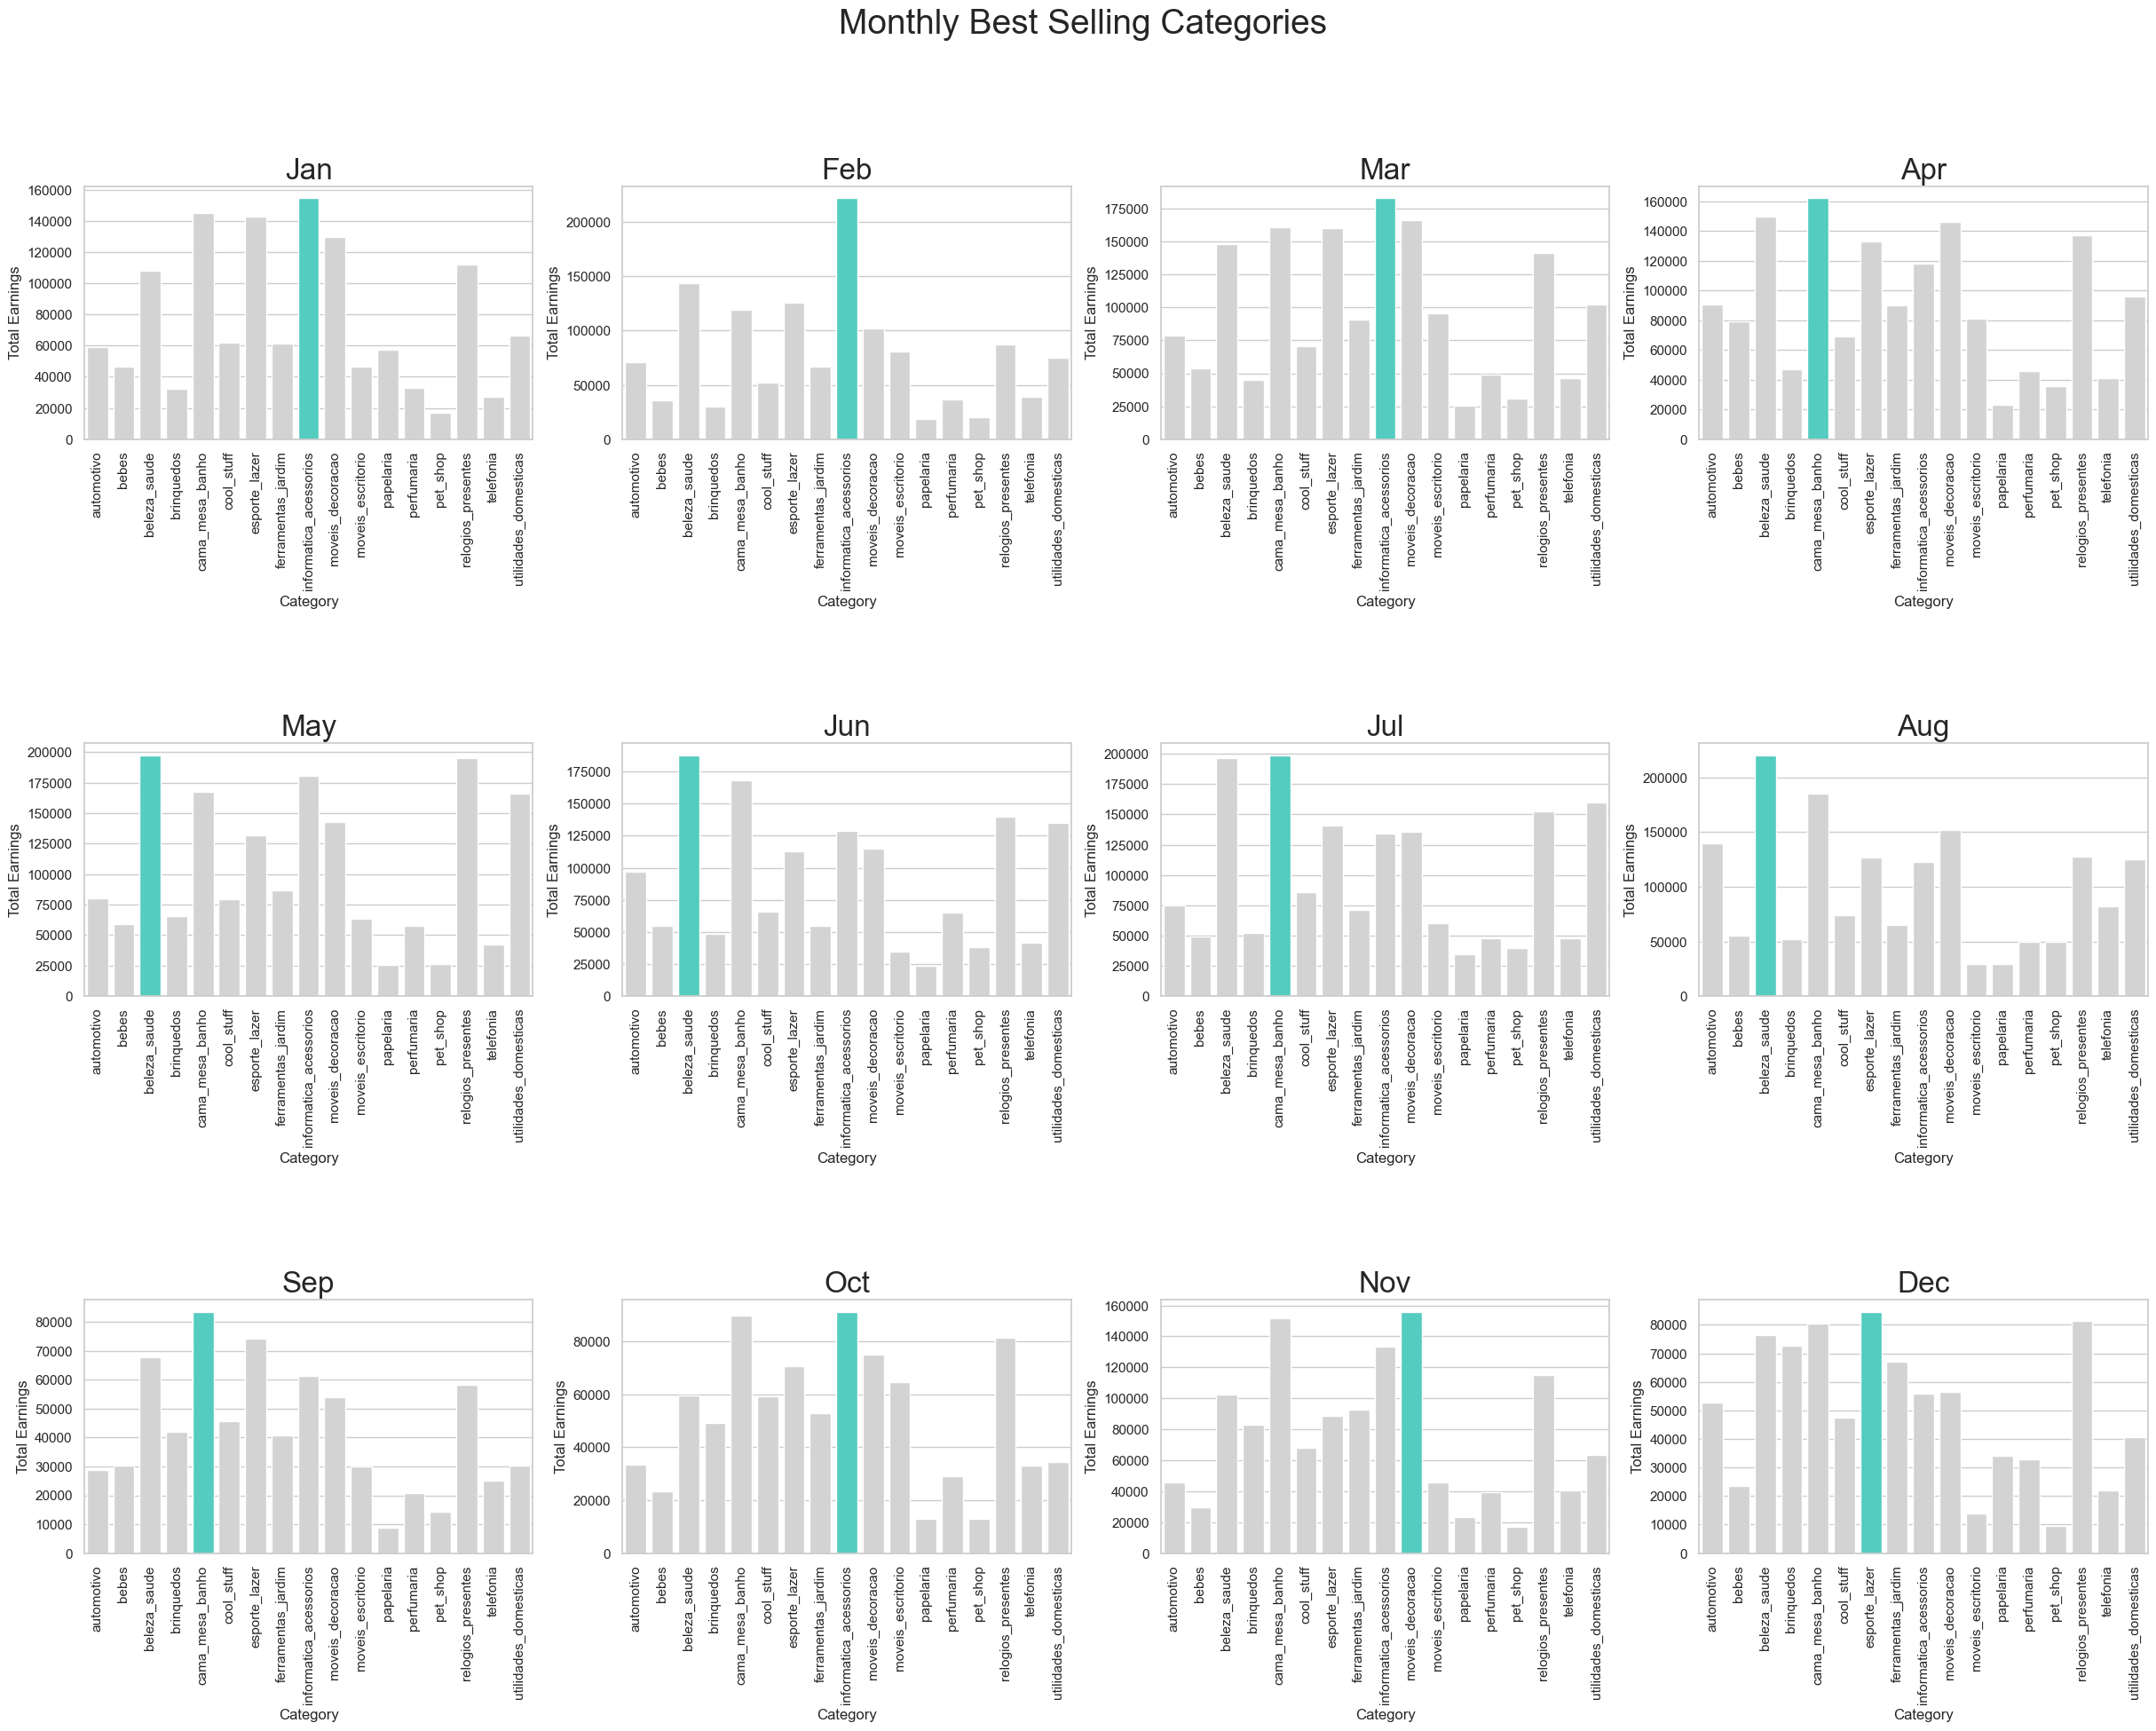

In [31]:
#Create custom palette for color of figure
def set_custom_palette(series, max_color='turquoise', other_color='lightgrey'):
    max_val = series.max()
    pal = []
    
    for item in series:
        if item == max_val:
            pal.append(max_color)
        else:
            pal.append(other_color)
    return pal

#Create the figure
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(30, 20))
plt.subplots_adjust(hspace=1.2)

months = sorted(best_monthly.columns)
month_names = [calendar.month_abbr[int(month)] for month in months]

for i, ax in enumerate(axes.flatten()):
    month_data = best_monthly[months[i]]
    palette = set_custom_palette(month_data, max_color='turquoise', other_color='lightgrey')
    sns.barplot(x=month_data.index, y=month_data.values, ax=ax, palette=palette)
    ax.set_title(month_names[i], fontsize=24)
    ax.set_xlabel('Category')
    ax.set_ylabel('Total Earnings')
    ax.tick_params(axis='x', rotation=90)

#Remove any empty subplots
if len(months) < len(axes.flatten()):
    for j in range(len(months), len(axes.flatten())):
        fig.delaxes(axes.flatten()[j])

plt.suptitle('Monthly Best Selling Categories', fontsize=28)
plt.show()

## The number of products each customer ordered

In [32]:
#Create amount of order for the same item
df['ord_new'] = df['order_item_id'].copy()
df.loc[df['order_item_id'].isin([7,8,9,10]), 'ord_new'] = '7 to 10'
df.loc[(df['order_item_id'] > 10), 'ord_new'] = '10 to 20'

C:\Users\HP\AppData\Local\Temp\ipykernel_19652\2152416068.py:3: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '7 to 10' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



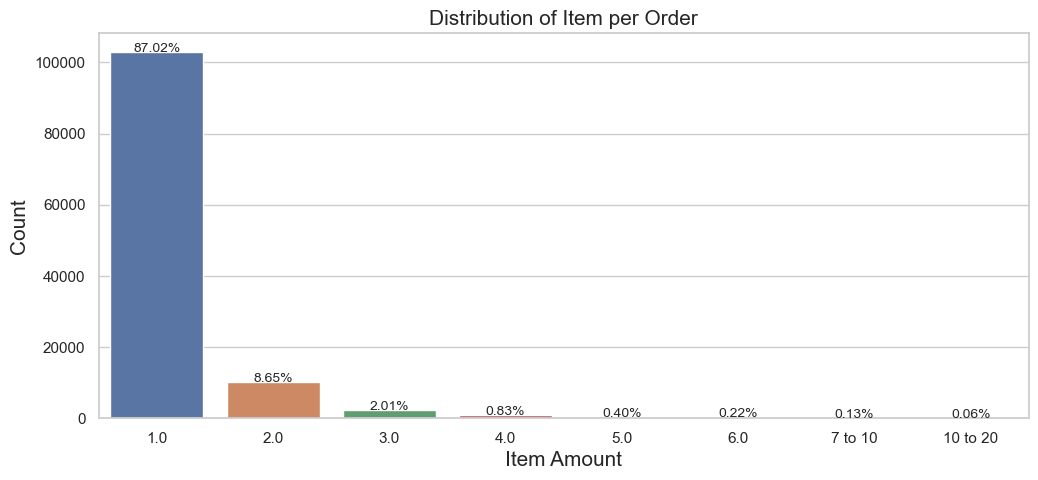

In [33]:
#Visualize feature or
plt.figure(figsize=(12,5))

g = sns.countplot(x='ord_new', data=df)
g.set_title("Distribution of Item per Order", fontsize=15)
g.set_xlabel("Item Amount", fontsize=15)
g.set_ylabel("Count", fontsize=15)

sizes = []
total = len(df)
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=10) 

plt.show()

In [34]:
# City disctribution
df['customer_city'].value_counts().sort_values(ascending=False)

customer_city
sao paulo         18738
rio de janeiro     8252
belo horizonte     3272
brasilia           2473
curitiba           1820
                  ...  
florinia              1
jacuizinho            1
pirapemas             1
cabeceiras            1
berilo                1
Name: count, Length: 4119, dtype: int64

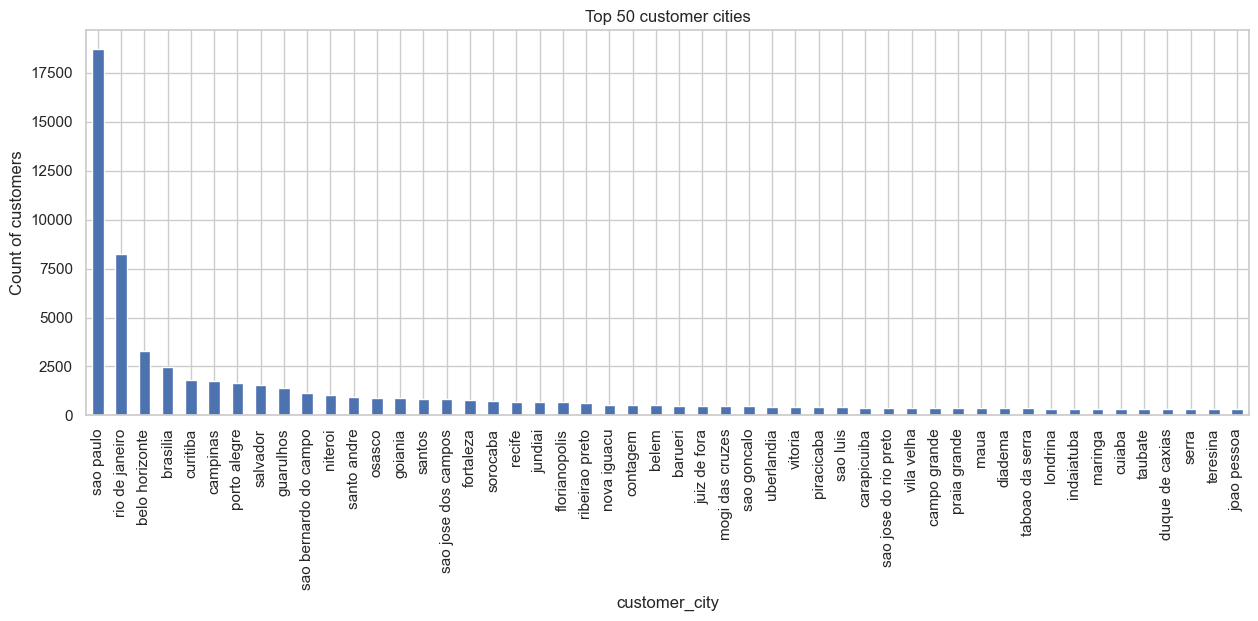

In [35]:
(
    df['customer_city']
    .value_counts()
    .sort_values(ascending=False)
    .head(50)
    .plot(kind='bar', figsize=(15, 5))
)

plt.title('Top 50 customer cities')
plt.ylabel('Count of customers');

## Customer count increased over the years

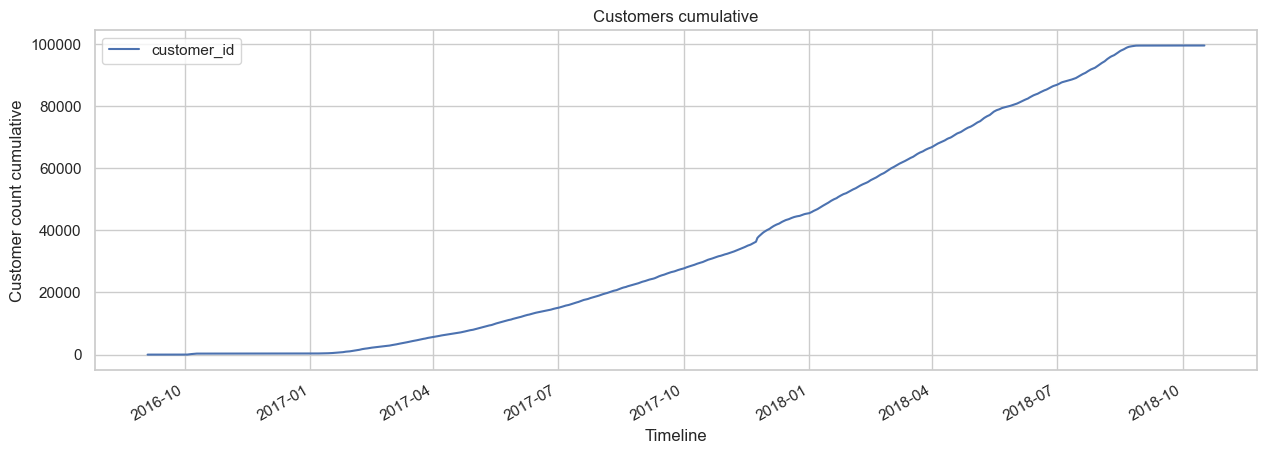

In [36]:
df_customer_dly = df.groupby(
    'customer_id',
    as_index=False).agg({
        'order_purchase_timestamp': 'min'
        })

df_customer_dly.groupby('order_purchase_timestamp').count().cumsum().plot(figsize=(15,5))
plt.title('Customers cumulative')
plt.xlabel('Timeline')
plt.ylabel('Customer count cumulative');

## Which customers ordered the most products?

Text(0, 0.5, 'Count of order lines')

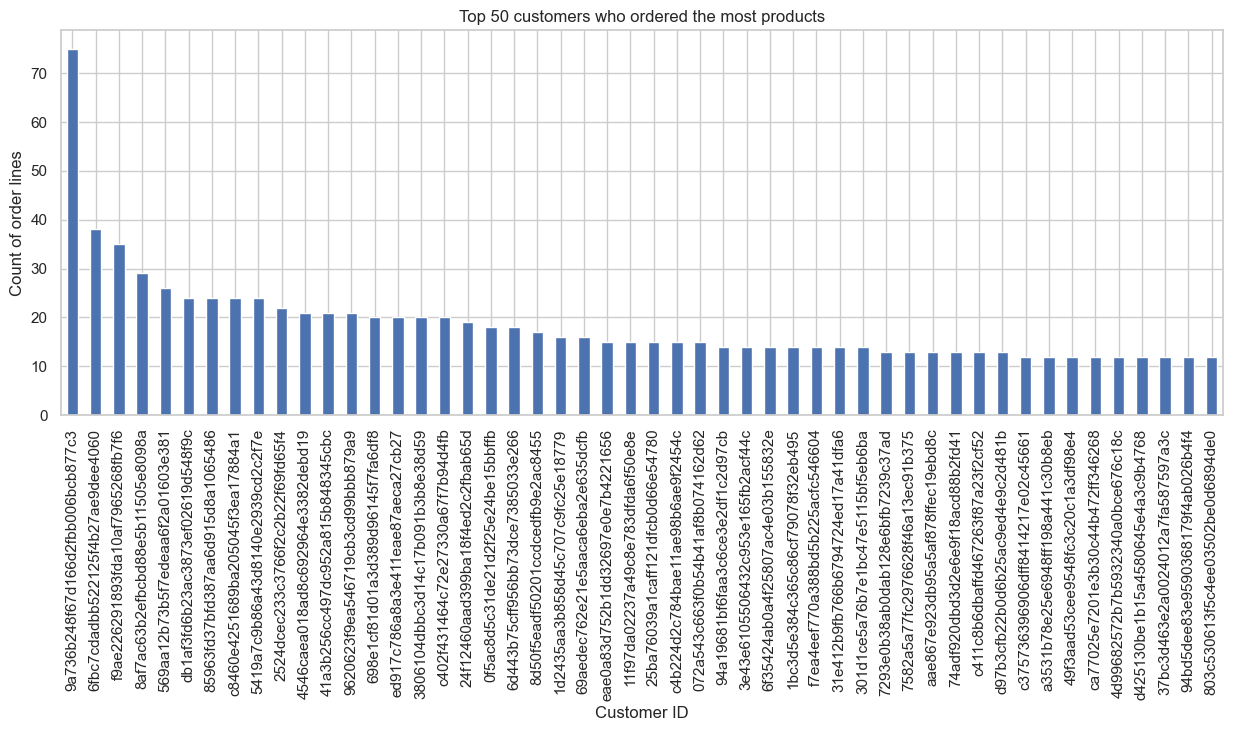

In [37]:
df.groupby('customer_unique_id').agg({'customer_id': 'count'}).sort_values('customer_id', ascending=False).head(50).plot(kind='bar',
        figsize=(15,5),
        legend=False);
plt.title('Top 50 customers who ordered the most products')
plt.xlabel('Customer ID')
plt.ylabel('Count of order lines')

## Which customers placed the most orders?

Text(0, 0.5, 'Count of orders')

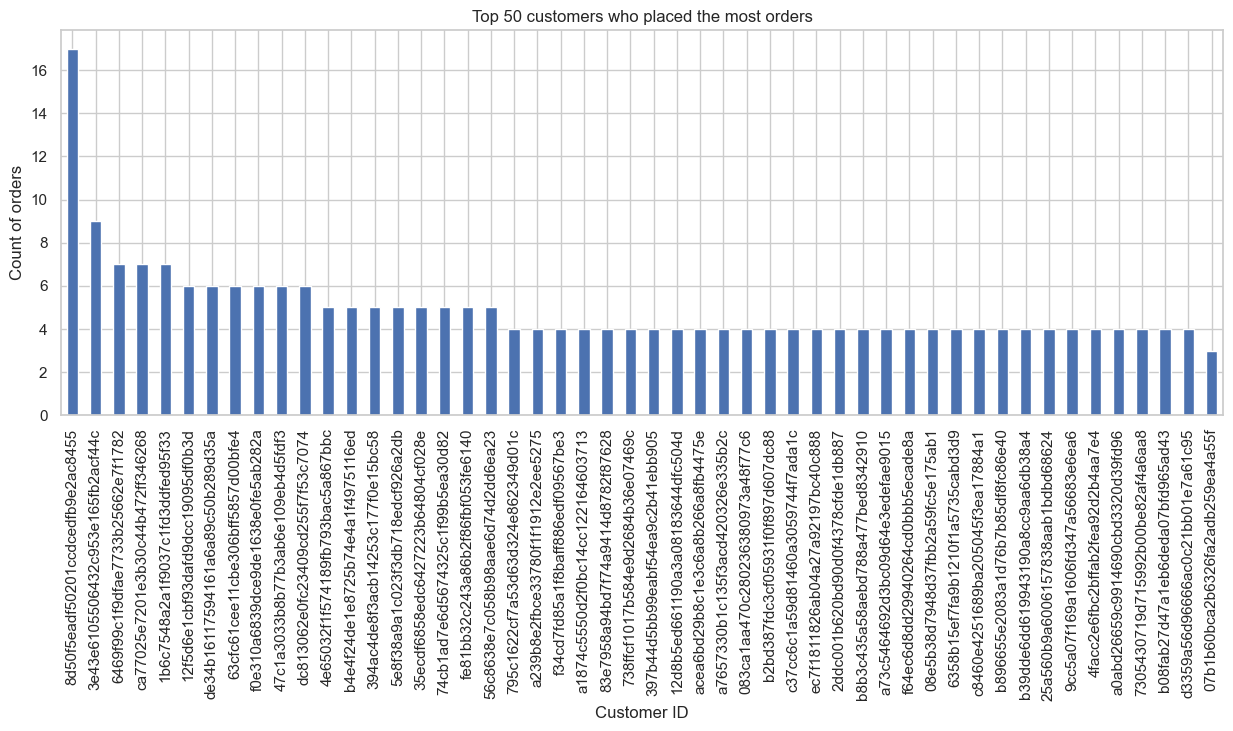

In [38]:
df.groupby(['customer_unique_id', 'order_id'], as_index=False).agg({'customer_id': 'count'}).groupby('customer_unique_id').agg({'order_id': 'count'})\
    .sort_values('order_id', ascending=False)\
    .head(50).plot(kind='bar', figsize=(15,5), legend=False);
plt.title('Top 50 customers who placed the most orders')
plt.xlabel('Customer ID')
plt.ylabel('Count of orders')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118434 entries, 0 to 118433
Data columns (total 42 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       118434 non-null  object        
 1   customer_id                    118434 non-null  object        
 2   order_status                   118434 non-null  object        
 3   order_purchase_timestamp       118434 non-null  datetime64[ns]
 4   order_approved_at              118434 non-null  object        
 5   order_delivered_carrier_date   118434 non-null  object        
 6   order_delivered_customer_date  118430 non-null  datetime64[ns]
 7   order_estimated_delivery_date  118434 non-null  object        
 8   order_time                     118434 non-null  object        
 9   delivery_time                  118434 non-null  object        
 10  date_ordinal                   118434 non-null  int64         
 11  

In [40]:
products_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32340 entries, 0 to 32339
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     32340 non-null  object 
 1   product_category_name_english  32340 non-null  object 
 2   product_name_lenght            32340 non-null  float64
 3   product_description_lenght     32340 non-null  float64
 4   product_photos_qty             32340 non-null  float64
 5   product_weight_g               32340 non-null  float64
 6   product_length_cm              32340 non-null  float64
 7   product_height_cm              32340 non-null  float64
 8   product_width_cm               32340 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.2+ MB


 ## What is the order composition in view of product category?

In [41]:
#products_trans.rename(columns={'product_category_name':'product_category_name_english'},inplace=True)

In [42]:
#products_trans.rename(columns={'product_category_name':'product_category_name_english'},inplace=True)
#df = pd.merge(df,products_trans[['product_id','product_category_name_english']], on='product_id', how='outer')

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118434 entries, 0 to 118433
Data columns (total 42 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       118434 non-null  object        
 1   customer_id                    118434 non-null  object        
 2   order_status                   118434 non-null  object        
 3   order_purchase_timestamp       118434 non-null  datetime64[ns]
 4   order_approved_at              118434 non-null  object        
 5   order_delivered_carrier_date   118434 non-null  object        
 6   order_delivered_customer_date  118430 non-null  datetime64[ns]
 7   order_estimated_delivery_date  118434 non-null  object        
 8   order_time                     118434 non-null  object        
 9   delivery_time                  118434 non-null  object        
 10  date_ordinal                   118434 non-null  int64         
 11  

In [44]:
#df.rename(columns = {'order_item_id': 'qty'}, inplace = True)

In [45]:
df['qty'] = df.loc[:, 'order_item_id']

In [46]:
df['order_line_cube_in_ltr']= df['product_length_cm']*df['product_height_cm']*df['product_width_cm']/1000*df['qty']

In [47]:
# Creating a category- order grouped dataframe
df_order_class_comp = df.groupby([
    'order_id',
    'product_category_name_english'
    ], as_index=False).agg({
        'product_id': 'count',
        'qty': 'sum',
        'price': 'sum',
        'order_line_cube_in_ltr': 'sum',
        'product_weight_g': 'sum',
        'estimated_duration': 'first',
        'shipping_duration': 'first',
        'shipping_time_delta': 'first',
        'order_purchase_timestamp': 'first'
        })

In [48]:
df_order_class_comp.rename(columns={
    'qty': 'total_qty',
    'price': 'total_price',
    'order_line_cube_in_ltr': 'total_cube',
    'product_weight_g': 'total_weight'
    }, inplace=True)

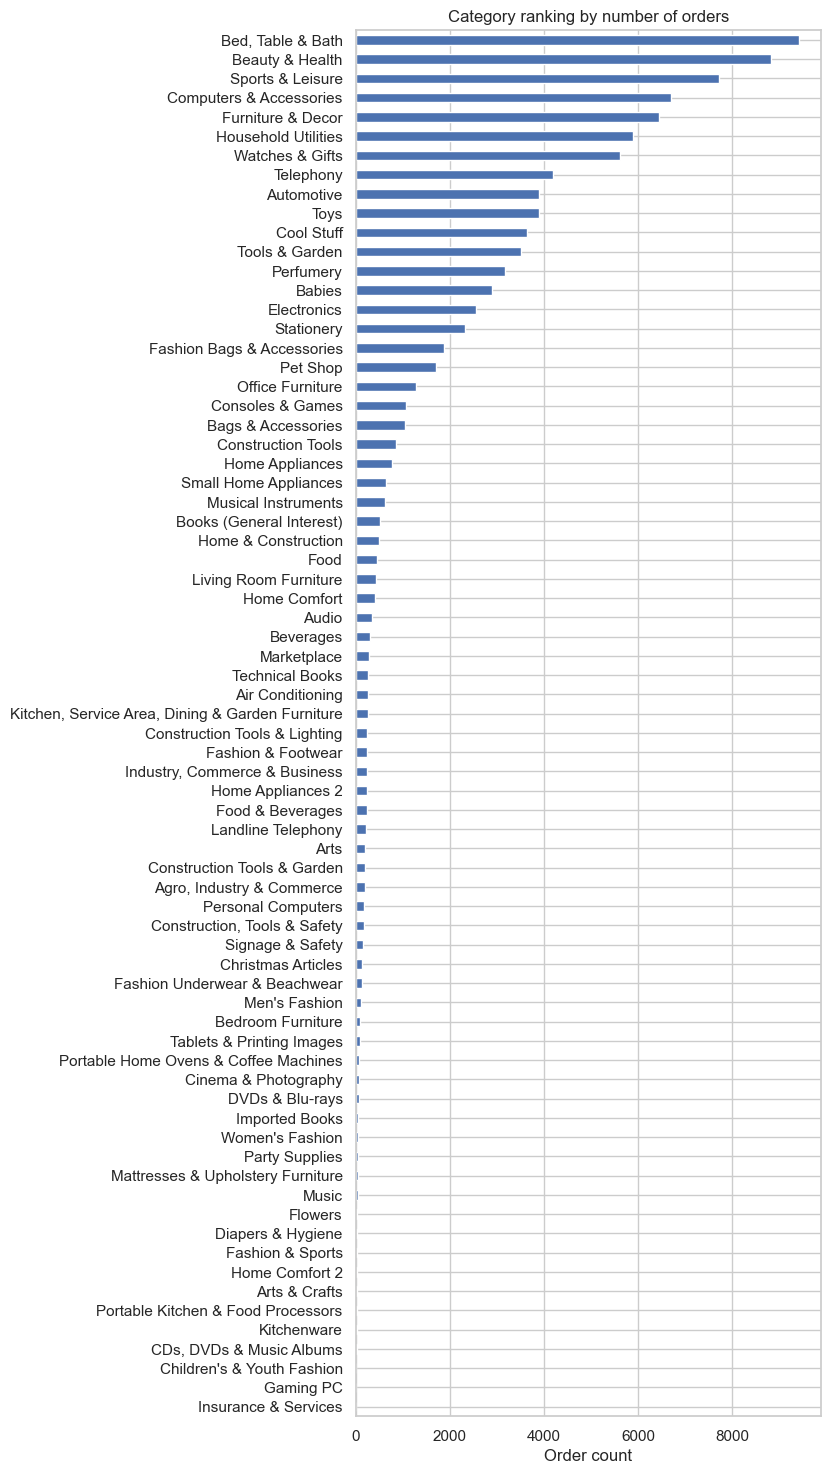

In [49]:
df_order_class_comp.groupby('product_category_name_english').agg({'order_id': 'count'}).sort_values('order_id').plot(kind='barh', figsize=(6,18), legend=False);
plt.title('Category ranking by number of orders')
plt.ylabel('');
plt.xlabel('Order count');

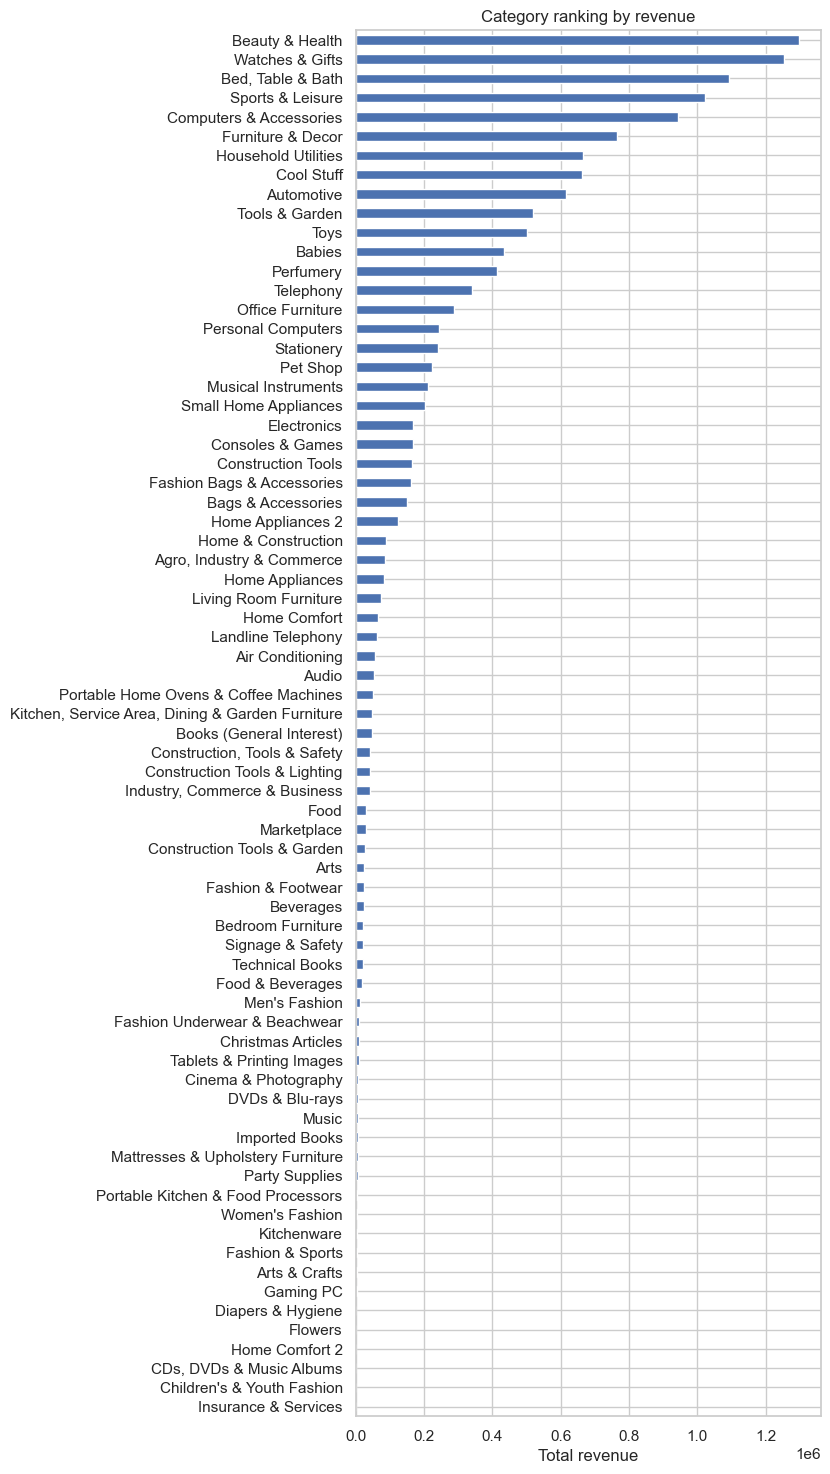

In [50]:
# Product category ranking by revenue
df_order_class_comp.groupby('product_category_name_english')\
    .agg({'total_price': 'sum'})\
    .sort_values('total_price')\
    .plot(kind='barh', figsize=(6,18), legend=False);
plt.title('Category ranking by revenue')
plt.ylabel('');
plt.xlabel('Total revenue');

# 4. Category correlation (similarity)


    Description:
    Return a matrix with order IDs as rows and category names on the columns with count of values where an order contained the product category

    INPUT:
    df - pandas dataframe
    row - field name to be used for the rows
    col - field name to be used for the columns
    elm - field name to be used as matrix elements (counte values)
    
    OUTPUT:
    mat_cat_order - category-order matrix 
    

In [51]:
# Creating a function that returns a sparse matrix
def create_category_order_matrix(df, row, col, elm):
    mat_cat_order = df.groupby([
        row,
        col
    ]).agg({elm: 'count'}).unstack().fillna(0)
    
    return mat_cat_order # return the user_item matrix

In [52]:
# Sparse matrix for categoy - orders
mat_cat_order = create_category_order_matrix(df_order_class_comp, 'product_category_name_english', 'order_id', 'total_qty')

In [53]:
mat_cat_order.head()

total_qty  \
order_id                      00010242fe8c5a6d1ba2dd792cb16214   
product_category_name_english                                    
Agro, Industry & Commerce                                  0.0   
Air Conditioning                                           0.0   
Arts                                                       0.0   
Arts & Crafts                                              0.0   
Audio                                                      0.0   

                                                                \
order_id                      00018f77f2f0320c557190d7a144bdd3   
product_category_name_english                                    
Agro, Industry & Commerce                                  0.0   
Air Conditioning                                           0.0   
Arts                                                       0.0   
Arts & Crafts                                              0.0   
Audio                                                      0.0   

                                                                \
order_id                      000229ec398224ef6ca0657da4fc703e   
product_category_name_english                                    
Agro, Industry & Commerce                                  0.0   
Air Conditioning                                           0.0   
Arts                                                       0.0   
Arts & Crafts                                              0.0   
Audio                                                      0.0   

                                                                \
order_id                      00024acbcdf0a6daa1e931b038114c75   
product_category_name_english                                    
Agro, Industry & Commerce                                  0.0   
Air Conditioning                                           0.0   
Arts                                                       0.0   
Arts & Crafts                                              0.0   
Audio                                                      0.0   

                                                                \
order_id                      00042b26cf59d7ce69dfabb4e55b4fd9   
product_category_name_english                                    
Agro, Industry & Commerce                                  0.0   
Air Conditioning                                           0.0   
Arts                                                       0.0   
Arts & Crafts                                              0.0   
Audio                                                      0.0   

                                                                \
order_id                      00048cc3ae777c65dbb7d2a0634bc1ea   
product_category_name_english                                    
Agro, Industry & Commerce                                  0.0   
Air Conditioning                                           0.0   
Arts                                                       0.0   
Arts & Crafts                                              0.0   
Audio                                                      0.0   

                                                                \
order_id                      00054e8431b9d7675808bcb819fb4a32   
product_category_name_english                                    
Agro, Industry & Commerce                                  0.0   
Air Conditioning                                           0.0   
Arts                                                       0.0   
Arts & Crafts                                              0.0   
Audio                                                      0.0   

                                                                \
order_id                      000576fe39319847cbb9d288c5617fa6   
product_category_name_english                                    
Agro, Industry & Commerce                                  0.0   
Air Conditioning                                           0.0   
Arts                

In [54]:
# Any order contained two articles of the same category?
len(np.where(mat_cat_order > 1))

2

1.Only two orders had two products of the same category.
2.Let's do some experimenting and develop an algorithm which returns similar categories based on the order history (Collaborative Filtering based on dot-product). I will use the new sparse matrix to do this.


    A function that calculates the similarity of every pair of category based on the dot product

    INPUT:
    product_category_name - (str) a product category name
    mat_cat_order - (Numpy matrix) matrix of product category by order ID: 
                The matrix elements are counts of instances.
    
    Output:
    similar_categories - Ordered list where the closest category are listed first
    

In [55]:
def find_similar_categories(product_category_name, mat_cat_order=mat_cat_order):
    # Calculate similarity and sort
    lst_orders = mat_cat_order.loc[product_category_name]
    arr_category = (mat_cat_order.index.tolist())
    unique_categories = len(mat_cat_order)
    
    dist_to_cat = []
    for cat in range(unique_categories):
        dist_to_cat.append(np.dot(lst_orders, mat_cat_order.iloc[cat]))
        
    df_dists = pd.DataFrame({
        'category': arr_category,
        'dist_to_cat': dist_to_cat
    }).sort_values('dist_to_cat', ascending=False)[1:]

    # create list of just the ids
    similar_categories = df_dists['category'].tolist()
   
    # remove the own user's id
    
    return similar_categories # return a list of the categories in order from most to least similar

In [56]:
# Let's check some categories
print('5 most similar categories to "sports & leisure": {}'.format(find_similar_categories('Sports & Leisure')[:5]))
print('5 most similar categories to "Furniture & Decor": {}'.format(find_similar_categories('Furniture & Decor')[:5]))
print('5 most similar categories to "Toys": {}'.format(find_similar_categories('Toys')[:5]))

5 most similar categories to "sports & leisure": ['Beauty & Health', 'Household Utilities', 'Watches & Gifts', 'Toys', 'Perfumery']
5 most similar categories to "Furniture & Decor": ['Bed, Table & Bath', 'Household Utilities', 'Tools & Garden', 'Home & Construction', 'Babies']
5 most similar categories to "Toys": ['Babies', 'Cool Stuff', 'Stationery', 'Sports & Leisure', 'Perfumery']


# How much likely first-time customer or repeated customer that bought 1, 2, 3 item per order ?

In [57]:
#Identify customers with more than one occurrence (Repeat Customer)
repeated =df.groupby('customer_unique_id').filter(lambda x: len(x) > 1)
repeated['repeat'] = 'repeated'

#Identify customers with one occurrence (First Time Customer)
first = df.groupby('customer_unique_id').filter(lambda x: len(x) == 1)
first['repeat'] = 'firsttime'

#Combine the two DataFrames into one
combined_df = pd.concat([repeated, first], ignore_index=True)

In [58]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118434 entries, 0 to 118433
Data columns (total 45 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       118434 non-null  object        
 1   customer_id                    118434 non-null  object        
 2   order_status                   118434 non-null  object        
 3   order_purchase_timestamp       118434 non-null  datetime64[ns]
 4   order_approved_at              118434 non-null  object        
 5   order_delivered_carrier_date   118434 non-null  object        
 6   order_delivered_customer_date  118430 non-null  datetime64[ns]
 7   order_estimated_delivery_date  118434 non-null  object        
 8   order_time                     118434 non-null  object        
 9   delivery_time                  118434 non-null  object        
 10  date_ordinal                   118434 non-null  int64         
 11  

In [59]:
def howmany_order(order_item_id):
    howmany_order = combined_df[combined_df['qty'] == order_item_id][['qty', 'repeat']]
    howmany_order_group = howmany_order.groupby('repeat').agg(tot_repeat=('repeat', 'count'))
    
    # Add 'firsttime' to the groupby result if it is missing
    if 'firsttime' not in howmany_order_group.index:
        howmany_order_group.loc['firsttime'] = [0]
    
    howmany_order_group['tot_perc_one'] = (howmany_order_group['tot_repeat'] / howmany_order_group['tot_repeat'].sum() * 100).round(1)
    return howmany_order_group

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118434 entries, 0 to 118433
Data columns (total 44 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       118434 non-null  object        
 1   customer_id                    118434 non-null  object        
 2   order_status                   118434 non-null  object        
 3   order_purchase_timestamp       118434 non-null  datetime64[ns]
 4   order_approved_at              118434 non-null  object        
 5   order_delivered_carrier_date   118434 non-null  object        
 6   order_delivered_customer_date  118430 non-null  datetime64[ns]
 7   order_estimated_delivery_date  118434 non-null  object        
 8   order_time                     118434 non-null  object        
 9   delivery_time                  118434 non-null  object        
 10  date_ordinal                   118434 non-null  int64         
 11  

In [61]:
howmany_order(1)

,tot_repeat,tot_perc_one
repeat,,
firsttime,81024,78.6
repeated,22033,21.4


In [62]:
howmany_order(2)

,tot_repeat,tot_perc_one
repeat,,
repeated,10239,100.0
firsttime,0,0.0


In [63]:
howmany_order(3)

,tot_repeat,tot_perc_one
repeat,,
repeated,2376,100.0
firsttime,0,0.0


In [64]:
def howmany_order_grouped_bar_plot(order_item_ids):
    # Initialize lists to store repeat values and totals for each order item
    repeat_values = []
    totals = []

    # Iterate over the order_item_ids
    for order_item_id in order_item_ids:
        # Filter the data based on the order_item_id
        order_group = howmany_order(order_item_id)

        # Reorder the rows to ensure consistent order in repeat values
        order_group = order_group.reindex(['firsttime', 'repeated'])

        # Append the repeat values and totals to the lists
        repeat_values.append(order_group.index.tolist())
        totals.append(order_group['tot_perc_one'].tolist())

    # Set the number of order items and repeat values
    num_order_items = len(order_item_ids)
    num_repeat_values = len(repeat_values[0])

    # Set the width of each bar
    bar_width = 0.8 / num_order_items

    # Set the x positions for the bars
    x = np.arange(num_repeat_values)

    # Set the colors for the bars
    bar_colors = ['blue', 'green', 'orange', 'red']  # Add more colors if needed

    # Set the figure size
    plt.figure(figsize=(15, 4))  # Adjust the width and height as desired

    # Create the grouped bar plot
    for i in range(num_order_items):
        plt.bar(x + i * bar_width, totals[i], color=bar_colors[i], width=bar_width, alpha=0.5)

        # Add data labels on the bars
        for j, total in enumerate(totals[i]):
            plt.text(x[j] + i * bar_width, total, str(total), ha='center', va='bottom')

    # Add labels and titles
    plt.xlabel('Repeat')
    plt.ylabel('Total')
    plt.title('First-Time vs Repeated Customer of Count of Product Per Order')

    # Set the x-axis tick labels
    plt.xticks(x + bar_width * (num_order_items - 1) / 2, repeat_values[0])

    # Create a legend for the order items
    plt.legend(order_item_ids)

    # Display the plot
    plt.show()

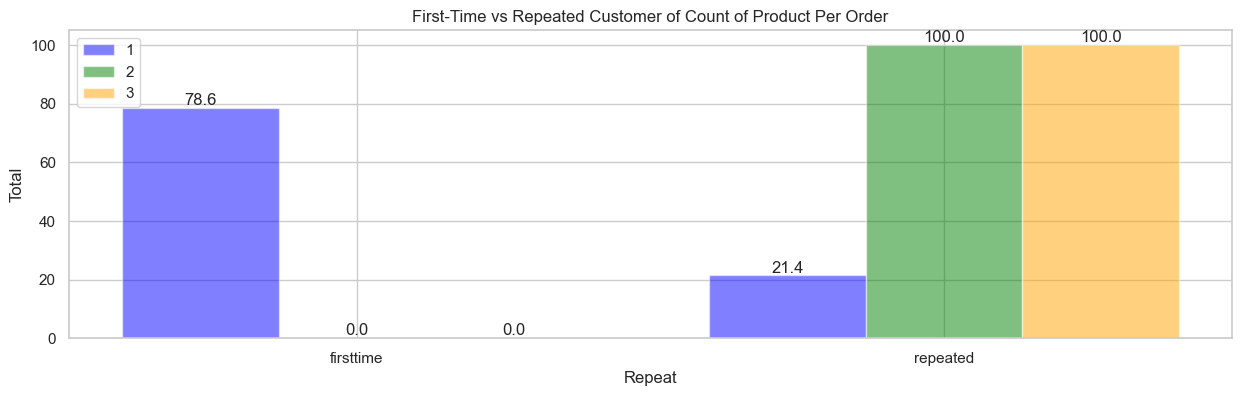

In [65]:
howmany_order_grouped_bar_plot([1, 2, 3])

Most likely the purchase of 1 product is come from first-time customer and the purchase of 2/3 products is come from repeated customer. Hence, it's obviously that if I can do suggest personalized buying experience to first-time customer based on their interest, then there would be more sales which in this cases to convert them to be repeated customer.

# Recommendation System

# Recommedation for new Customers

In [66]:
def find_pop_n_products(data, n):
    grouping = data.groupby(['product_id', 'product_category_name_english']).agg(num_product=('product_id', 'count'))
    sorted_group = grouping.sort_values(by='num_product', ascending=False).reset_index()
    top_n_products = sorted_group[['product_id', 'product_category_name_english']].head(n)
    print(f"Top {n} items:\n {top_n_products}")

In [67]:
#Testing Recommendation for the product
recommendation = find_pop_n_products(df,3)

Top 3 items:
                          product_id product_category_name_english
0  aca2eb7d00ea1a7b8ebd4e68314663af             Furniture & Decor
1  99a4788cb24856965c36a24e339b6058             Bed, Table & Bath
2  422879e10f46682990de24d770e7f83d                Tools & Garden


# Recommendation for Existing Customer

In [68]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, cross_validate
import pickle


# Filter relevant columns and drop NaN values
data = df[['customer_id', 'product_id', 'product_category_name_english']].dropna()

# Create a user-item-rating matrix
data['rating'] = 1  # Assign a default rating of 1 for interactions

# Map product_id to product_category_name
product_id_to_category = dict(zip(data['product_id'], data['product_category_name_english']))

# Preprocess the data to fit the Surprise library format
reader = Reader(rating_scale=(1, 1))
dataset = Dataset.load_from_df(data[['customer_id', 'product_id', 'rating']], reader)

# Split the data into training and test sets
trainset, testset = train_test_split(dataset, test_size=0.2)

# Initialize and train the SVD model
svd = SVD(n_factors=30, n_epochs=25, biased=True, lr_all=0.005, reg_all=0.02, verbose=True)
svd.fit(trainset)

# Evaluate the model using cross-validation
cross_validate(svd, dataset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Save the trained model to a file
model_filename = 'svd_recommender_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(svd, file)

# Load the model from the file
with open(model_filename, 'rb') as file:
    loaded_svd = pickle.load(file)


Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
P

In [69]:

# Function to get top N recommendations for a given user
def get_top_n_recommendations(model, user_id, n=10):
    # Get a list of all product_ids
    product_ids = data['product_id'].unique()
    
    # Predict ratings for all products for the given user
    predictions = [model.predict(user_id, product_id) for product_id in product_ids]
    
    # Sort predictions by estimated rating in descending order
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    # Get top N product_ids with the highest estimated rating
    top_n_product_ids = [pred.iid for pred in predictions[:n]]
    
    # Map product_ids to product_category_names
    top_n_product_categories = [product_id_to_category[product_id] for product_id in top_n_product_ids]
    
    return top_n_product_categories


In [70]:
# Get recommendations for a specific user
user_id = 'b09dfc21c8731d3d08e35c06c4992922'  # Replace with a specific user ID
top_n_recommendations = get_top_n_recommendations(loaded_svd, user_id, n=7)
print(f"Top 10 recommendations for user {user_id}: {top_n_recommendations}")

Top 10 recommendations for user b09dfc21c8731d3d08e35c06c4992922: ['Furniture & Decor', 'Furniture & Decor', 'Toys', 'Household Utilities', 'Furniture & Decor', 'Furniture & Decor', 'Living Room Furniture']
